##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [13]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
#             Model = ['wind_speed','PPFD_Avg','AirTC_Avg','VPD',
#                     'Temp','VWC','Sedge','Shrub','Grass','Upland']
            Model = ['PPFD_Avg','AirTC_Avg','VPD','wind_speed',
                    'Temp','VWC','Sedge','Shrub','Grass','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','VPD','wind_speed','VWC']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model=['H','AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg',
                  'Table_1','Delta_Table_1','VWC_1','Delta_VWC_1','VWC_2','Delta_VWC_2',
                  'Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Delta_Temp_1','Delta_Temp_2',
                  'Active_Layer_1','Total_Rain_mm_Tot','wind_speed','u*','wind_dir','air_pressure',
                  'Time','DOY']
        if Scope == 'Test':
            Model = ['Wind Spd','Ta','Rn','VWC']
    return(Model)

def Combos(Model,L,factor=None):
    Models=[]
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
#     print('Models: ',Models)
    return(Models)

def Stats(mse,se,r2,j,i,params):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],
                            'MSE':[mse],
                            'Size':j,
                            'Number':i,
                            'HiddenNodes':params['N'],
                            'SE':[se],
                            'r2':[r2],
                            'Performance':0,
                            'K':[params['K']]})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

FirstRun = True
# FirstRun = False

MP=True
# MP=False
Scope = 'Full'
# Scope = 'Test'
# if Scope == Test:
#     processes=2
# else:
processes=3
    
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
# Site='FishIsland'
Site = 'Illisarvik'
# target='fch4'
alpha = .05
# print(cwd)


pd.set_option('max_colwidth',200)
def Display (tar,prog1,prog2,MdLs,MdL):
    clear_output()
    display(tar)
    display(prog1)
    display(prog2)
    display(MdLs)
    display(MdL)
    
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )

In [3]:
depth = None
Time = time.time()
FirstRun = True
# FirstRun = False
kwit = 0
Pthresh=1
if __name__ == '__main__':
    for target in ['fco2','fch4']:
        XVarriables=ModSelect(Scope,Site)
#         if target == 'fch4' and Site == 'FishIsland':
#             XVarriables.append('fco2')
        if FirstRun == True:
            start=1
            
            stop = len(XVarriables)+1
            if depth is not None:
                stop = depth
#             stop += 1#2
            try:shutil.rmtree(cwd+'/'+Site+'/'+target+'/')
            except:pass
            os.mkdir(cwd+'/'+Site+'/'+target+'/')
        else:
            params = Dense.Params(Scope,target,MP)
            params['Dpath'] = cwd+'/'+Site+'/'
            Records = pd.read_csv(cwd+'/'+Site+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            start = Records['Size'].max()+1
            Level = Records.loc[Records['Size']==start-1]
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            
            stop = len(XVarriables)
            if start >1:
                Factors = Level.loc[Level['Performance']>=Pthresh,'Model'].values
#             print(Factors)
                 
        tar.value=target
        prog1 = FloatProgress(min=start, max=stop,description='Running:')
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdLs = HTML(
            value=" ",placeholder='Models: ',description='Models: ',
        )
        MdL = HTML(
            value=" ",placeholder='Testing: ',description='Testing: ',
        )
        Display (tar,prog1,prog2,MdLs,MdL)

        for j in range(start,stop):  
            print(j)
            if j == 1 and Site == 'Illisarvik' and target == 'fco2': Inputs = [['PPFD_Avg']]
#             elif j == 2 and Site == 'Illisarvik' and target == 'fco2': Inputs = [['PPFD_Avg','VPD']]
#             elif j == 3 and Site == 'Illisarvik' and target == 'fco2': Inputs = [['PPFD_Avg','VPD','VWC']]
# #                                                                                  ['PPFD_Avg','VWC'],['PPFD_Avg','Out_of_Basin']]
# #             elif j == 2 and Site == 'Illisarvik' and target == 'fch4': Inputs = [['Sedge','VWC']]
            elif j == 1 and Site == 'Illisarvik' and target == 'fch4': Inputs = [['Sedge']]#,['Out_of_Basin']]
            elif j == 2 and Site == 'Illisarvik' and target == 'fch4': Inputs = [['Sedge','VWC']]
#             elif j == 3 and Site == 'Illisarvik' and target == 'fch4': Inputs = [['Sedge','VWC','Temp']]
#             elif j == 4 and Site == 'Illisarvik' and target == 'fch4': Inputs = [['Sedge','VWC','Temp','PPFD_Avg'],
#                                                                               ['Sedge','VWC','Temp','Shrub']]
#           
                
            elif j == 1: Inputs = (Combos(XVarriables,j))
            else: Inputs = (Combos(XVarriables,j,Factors))
            MdLs.value=str(len(Inputs))
            i = 0
            procede = True
            for Input in Inputs:
                if FirstRun == False:
                    if Records.loc[Records['Size']==j].isin({'Number':[i]}).any().any()==True:
                        procede = False
                    else:
                        procede = True
                if procede == True:
                    params = Dense.Params(Scope,target,MP)
                    params['Dpath'] = cwd+'/'+Site+'/'
                    params['Spath'] = params['Dpath']+'/'+target+'/'+str(j)+'_'+str(i)+'/'
                    try:os.mkdir(params['Spath'])
                    except:pass
                    params['Sname'] = 'Y_'
                    params['Inputs'] = Input
                    MdL.value='#'+str(i)+' '+str(params['Inputs'])
#                     Display (tar,prog1,prog2,MdLs,MdL)
                    print('Runtime: ',time.time()-Time)
                    params['Model'] = '+'.join(params['Inputs'])
                    RST = RSTF.ReadStandardTimeFill(params,'AllData.csv',
                                           FPFill=[10,['Sedge','Shrub','Grass','Out_of_Basin']])#,resample='2H')
                    if target == 'ER':
                        RST.Master = RST.Master.loc[RST.Master['fco2']>0]
                    RST.Scale(params['target'],params['Inputs']) 
                    print(RST.y.shape)
                    y = RST.y*1.0
                    X = RST.X*1.0
                    Ni = len(Input)
                    Ns = y.shape[0]
                    No = 1
                    a = 2
                    params['N']=int(Ns/(a*(Ni+No)))
                    params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
                    Y_hat=[]
                    y_true=[]
                    X_true=[]
                    index=[]
                    ones=[]
                    prog2.value=0
                    pool = Pool(processes=processes,maxtasksperchild=75)
                    for k,results in enumerate(pool.imap(partial(Dense.Bootstrap,params=params,X=X,y=y),range(params['K']))):
                        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                        y_true.append(RST.YScaled.inverse_transform(results[1]))
                        X_true.append(RST.XScaled.inverse_transform(results[2]))
                        ones.append(results[3])
                        prog2.value=(k+1)/params['K']*100
                    pool.close()
                    Y_hat = np.squeeze(np.asanyarray(Y_hat))
                    y_true = np.squeeze(np.asanyarray(y_true))
                    X_true = np.asanyarray(X_true)
                    ones = np.asanyarray(ones)
                    params['Memory'] = .95
                    pool = Pool(processes=1,maxtasksperchild=75)
                    for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
                     Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones),range(1))):
                         mse,se,r2 = results
                    pool.close()
                    if i == 0 and FirstRun == True:Level = Stats(mse,se,r2,j,i,params)
                    else:
                        Level = Level.loc[Level['Size']==j]
                        Level = Level.append(Stats(mse,se,r2,j,i,params))
#                     print(Level)
                    Level.to_csv('Temp.csv')
                i += 1
                prog1.value=j+i/len(Inputs)
                
            Level['Thresh'] = Level['MSE']+Level['SE']
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            if j == 1:
                Level.loc[Level['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*1,'Performance']+=1
            else:
                if Records['MSE'].min()>Min['MSE'].values[0]:
                    Level.loc[Level['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*1,'Performance']+=1
            Top = Level.loc[Level['Performance']==Level['Performance'].max()]
            Smalls = Top.nsmallest(1,'MSE')
            Level.loc[Level.MSE.isin(Smalls['MSE'].values)==False,'Performance']-=1
            if j == 1:
                Records = Level
            else:
                Records = Records.append(Level)
            Factors = Level.loc[Level['Performance']>=Pthresh,'Model'].values
            Records = Records.reset_index(drop=True)
            Records.drop(Records.columns[Records.columns.str.contains('Unnamed',case = False)],axis = 1)
            if Scope == 'Full':
                Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')
            else:
                Records.to_csv(params['Dpath']+'/'+target+'_Runs2.csv')
            if Level['Performance'].max()<Pthresh and j>1:
                break

HTML(value='fch4', description='Target: ', placeholder='Target: ')

FloatProgress(value=1.0, description='Running:', max=11.0, min=1.0)

FloatProgress(value=0.0, description='Bootstrapping:')

HTML(value=' ', description='Models: ', placeholder='Models: ')

HTML(value=' ', description='Testing: ', placeholder='Testing: ')

1
Runtime:  9789.405273199081
(876,)
2
Runtime:  10002.70479297638
(876,)
3
Runtime:  10225.62547326088
(876,)
Runtime:  10421.135456085205
(876,)
Runtime:  10638.48821234703
(876,)
Runtime:  10849.866371631622
(876,)
Runtime:  11056.109289884567
(876,)
Runtime:  11257.623475313187
(876,)
Runtime:  11458.56367111206
(876,)
Runtime:  11666.30812883377
(876,)
4
Runtime:  11872.303287029266
(876,)
Runtime:  12085.91646695137
(876,)
Runtime:  12293.4453728199
(876,)
Runtime:  12499.143630981445
(876,)
Runtime:  12694.385731935501
(876,)
Runtime:  12896.478439807892
(876,)
Runtime:  13104.2250790596
(876,)
5
Runtime:  13301.642310857773
(876,)
Runtime:  13503.496134281158
(876,)
Runtime:  13702.83269739151
(876,)
Runtime:  13900.887053966522
(876,)
Runtime:  14098.683035850525
(876,)
Runtime:  14302.173824310303
(876,)
6
Runtime:  14502.526143789291
(876,)
Runtime:  14716.812994003296
(876,)
Runtime:  14920.207464694977
(876,)
Runtime:  15120.0784637928
(876,)
Runtime:  15373.717825174332
(

In [107]:
print(Records)

          Model         MSE  Size  Number  HiddenNodes         SE        r2  \
0      PPFD_Avg  108.897557     1       0          219   8.338147  0.035473   
1     AirTC_Avg  103.263229     1       1          219   9.101731  0.085378   
2           VPD  107.756707     1       2          219  10.134949  0.045578   
3    wind_speed  110.497419     1       3          219  10.802573  0.021303   
4          Temp  112.306877     1       4          219  11.083581  0.005276   
5           VWC  103.611094     1       5          219   9.536351  0.082297   
6         Sedge   97.573839     1       6          219   8.368755  0.135770   
7         Shrub  108.302372     1       7          219  10.808424  0.040745   
8         Grass  102.924988     1       8          219   9.591366  0.088374   
9  Out_of_Basin  107.133056     1       9          219  10.284429  0.051102   

   Performance   K      Thresh  
0            0  15  117.235703  
1            1  15  112.364959  
2            0  15  117.891656 

In [24]:
prog1 = FloatProgress(min=1, max=2,description='Running:')
prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
MdLs = HTML(
    value=" ",
    placeholder='Models: ',
    description='Models: ',
)
MdL = HTML(
    value=" ",
    placeholder='Testing: ',
    description='Testing: ',
)
Display (tar,prog1,prog2,MdLs,MdL)

# i = 1

target = 'fch4'
MP = True


try:
    os.mkdir(params['Spath'])
except:
    pass

Inputs = [['Wtr Tbl Trnd'],['Water Table']]

Inputs=[['H','AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg',
      'Table_1','Delta_Table_1','VWC_1','Delta_VWC_1','VWC_2','Delta_VWC_2',
      'Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Delta_Temp_1','Delta_Temp_2',
      'Active_Layer_1','Total_Rain_mm_Tot','wind_speed','u*','wind_dir','air_pressure',
      'Time','DOY']]

# Inputs =[['VPD', 'AirTC_Avg', 'VWC_2', 'air_pressure', 'Delta_VWC_1',
#        'Delta_VWC_2', 'wind_speed', 'Total_Rain_mm_Tot', 'Delta_Table_1',
#        'u*']]

Inputs=[['PPFD_Avg', 'Total_Rain_mm_Tot', 'Delta_Temp_1', 'air_pressure',
       'Delta_VWC_2', 'Delta_Table_1', 'H', 'VWC_2', 'wind_speed', 'u*','Active_Layer_1']]
Inputs = [['Sedge','Grass','AirTC_Avg','VWC','wind_speed']]

# i = 4
# for target in ['fco2','fch4']:
for target in ['fch4']:
#     Name = 'Taglu/'+target
    tar.value=target
    Name = 'Test/'+target
    for i,Input in enumerate(Inputs):
        i =0# 7
        j = len(Input)
        params = Dense.Params(Scope,target,MP,L=1)
#         params['N']=2
        params['Dpath'] = cwd+'/'+Site+'/'
        params['Sname'] = 'Y_'
    #     params['K']=3
        params['Verbose']=0
        params['validation_split']= .2
    #     params['patience']=15
    #     MP = False
    #     params['patience']=2
#         RST = RSTF.ReadStandardTimeFill(params,'TagluData.csv')#.resample('H')
        RST = RSTF.ReadStandardTimeFill(params,'AllData.csv')#.resample('H')
        params['Spath'] = params['Dpath']+Name+'/'+str(j)+'_'+str(i)+'/'
        params['Inputs'] = Input
        params['Model'] = '+'.join(params['Inputs'])
        RST.Scale(params['target'],params['Inputs']) 
        y = RST.y*1.0
        X = RST.X*1.0
        if params['N'] is None:
            Ni = len(Input)
            Ns = y.shape[0]
            No = 1
            a = 2
#             params['N']=int(Ns/(a*(Ni+No)))
            ## Rule by Maier et al. 1998
            A = int(2*Ni+No)
            B = int(2*Ns/((Ni+No)))
            if A<B:params['N']=A
            else:params['N']=B
            print(A,B,params['N'])
            params['N']=B
        params['epochs'] = 200
        params['K']=30
        params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
        Y_hat=[]
        y_true=[]
        X_true=[]
        index=[]
        ones=[]
        prog2.value=0
        print(params)
        print(params['N'])
        if MP == False:
            for k in range(params['K']):
                Time2 = time.time()
                results = Dense.Bootstrap(k,params,X,y)
                Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                y_true.append(RST.YScaled.inverse_transform(results[1].reshape(-1,1)))
                X_true.append(RST.XScaled.inverse_transform(results[2]))
                ones.append(results[3])
                prog2.value=(k+1)/params['K']*100
#                 print(metrics.mean_squared_error(y_true[k],Y_hat[k]))
        else:
            pool = Pool(processes=processes,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Bootstrap,params=params,X=X,y=y),
                                                 range(0,params['K']))):
                Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                y_true.append(RST.YScaled.inverse_transform(results[1].reshape(-1,1)))
                X_true.append(RST.XScaled.inverse_transform(results[2]))
                ones.append(results[3])
                prog2.value=(k+1)/params['K']*100
#                 print(metrics.mean_squared_error(y_true[k],Y_hat[k]))
            pool.close()
        Y_hat = np.squeeze(np.asanyarray(Y_hat))
        y_true = np.squeeze(np.asanyarray(y_true))
        X_true = np.asanyarray(X_true)
        ones = np.asanyarray(ones)
        params['Memory'] = .95
        print(params)
        mse,se,r2 = Dense.Sort_outputs(k,params,Y_hat,y_true,X_true,ones)
        if i == 0:
            Level = Stats(mse,se,r2,j,i,params)
        else:
            Level2 = Stats(mse,se,r2,j,i,params)
            Level = Level.append(Level2)
    #     print(Level)
        i +=1
    Level['Thresh']=Level['MSE']+Level['SE']
    # if Name.split('_')[0] == 'ER':
    #     Name = Name + '_Runs'
#     Level.to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'+target+'_Taglu.csv')
    Level.to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'+target+'_Test.csv')
    print(Level)
    
#     0.562419 
#     0.862799

HTML(value='fch4', description='Target: ', placeholder='Target: ')

FloatProgress(value=1.0, description='Running:', max=2.0, min=1.0)

FloatProgress(value=0.0, description='Bootstrapping:')

HTML(value=' ', description='Models: ', placeholder='Models: ')

HTML(value=' ', description='Testing: ', placeholder='Testing: ')

11 292 11
{'proc': 3, 'K': 30, 'epochs': 200, 'target': 'fch4', 'Save': {'Weights': True, 'Model': True}, 'Loss': 'mean_squared_error', 'Memory': 0.31333333333333335, 'validation_split': 0.2, 'iteration': 1, 'Verbose': 0, 'Eval': True, 'patience': 20, 'HiddenLayers': 1, 'N': 292, 'Dpath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/', 'Sname': 'Y_', 'Spath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/Test/fch4/5_0/', 'Inputs': ['Sedge', 'Grass', 'AirTC_Avg', 'VWC', 'wind_speed'], 'Model': 'Sedge+Grass+AirTC_Avg+VWC+wind_speed'}
292
{'proc': 3, 'K': 30, 'epochs': 200, 'target': 'fch4', 'Save': {'Weights': True, 'Model': True}, 'Loss': 'mean_squared_error', 'Memory': 0.95, 'validation_split': 0.2, 'iteration': 1, 'Verbose': 0, 'Eval': True, 'patience': 20, 'HiddenLayers': 1, 'N': 292, 'Dpath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/', 'Sname': 'Y_', 'Spath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/Test/fch4/5_0/', 'Inputs': ['Sedge', 'Grass', 'AirTC_Avg', 'VWC', 'wind_s

# Model

                                    Model        MSE  Size  Number  \
5_0  Sedge+Grass+AirTC_Avg+VWC+wind_speed  36.383356     5       0   

     HiddenNodes        SE        r2  Performance   K     Thresh  
5_0          292  5.104931  0.677378            0  30  41.488287  


<IPython.core.display.Javascript object>


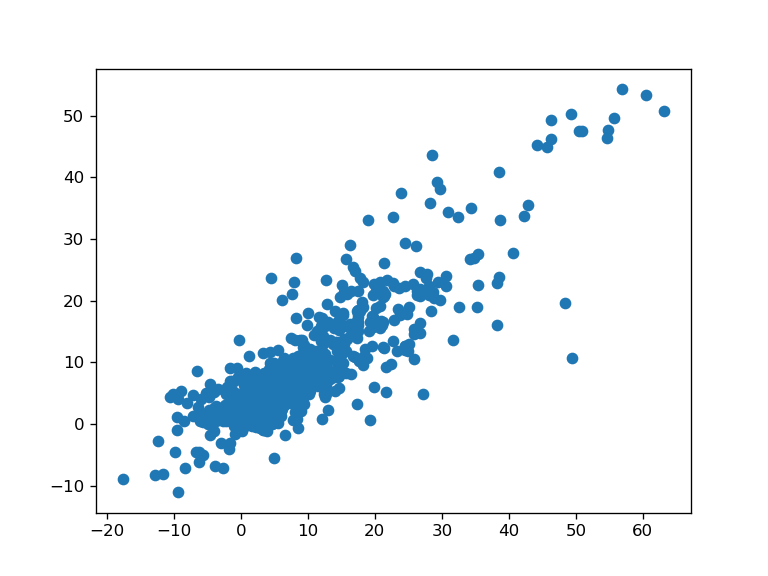

0.7511574598598103
8.136641231586585
8.1988535


In [25]:
print(Level)
plt.figure()
plt.scatter(y_true.mean(axis=0),Y_hat.mean(axis=0))
print(metrics.r2_score(y_true.mean(axis=0),Y_hat.mean(axis=0)))
# plt.figure()
# plt.plot(y_true.mean(axis=0))
# plt.plot(Y_hat.mean(axis=0))
print(y_true.mean(axis=0).mean())
print(Y_hat.mean(axis=0).mean())
# plt.figure()
# plt.plot(X_true[0])


In [ ]:
# plt.figure()
# plt.plot(RST.Master['SoilMoist(1)'],c='b',label='Center_them')
# plt.plot(RST.Master['SoilMoist(4)'],c='r',label='Rim_them')
# plt.legend()
# plt.twinx()
# plt.plot(RST.Master['VWC_1'],c='g',label='Center_me')
# plt.plot(RST.Master['VWC_2'],c='orange',label='Rim_me')
# plt.legend()
# print(RST.Master['VWC_2'].min())
# print(RST.Master['VWC_2'].max())

In [ ]:

# Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')

In [ ]:
print(RST.Master['PPFD_Avg'].quantile(.95))
# Level['Thresh']=Level['MSE']+Level['SE']
# Level.to_csv(params['Dpath']+Name+'.csv')j
# plt.figure()
# p

In [ ]:
print(Level.loc[Level.MSE.isin(Smalls['MSE'].values)==False,'Performance'])
print(Smalls)

In [ ]:
# print(int(Ns/(a*(Ni+No))))
plt.figure()
plt.scatter(RST.Master['Active Layer'],RST.Master['fch4'],s=2)

In [ ]:


print(np.mean(a),np.mean(b))
# Level#.to_csv(params['Dpath']+Name+'.csv')
Level['Upper']=Level['SE']+Level['MSE']
print(Level)#[['Model','Upper']])

In [ ]:
# print(params)

# Level = Stats(mse,se,j,i,params)
# Level.to_csv(params['Dpath']+target+'_Final_Runs.csv')

# plt.figure()
# print(RST.Master
#      )

# pool = Pool(processes=1,maxtasksperchild=75)
# for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
#  Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones),range(1))):
#      mse,se = results
# pool.close()

# plt.scatter(Y_hat,y_true)
# print(metrics.mean_squared_error(y_true,Y_hat))
# print(metrics.r2_score(y_true,Y_hat))

# plt.figure()

# plt.plot(Y_hat)
# plt.plot(y_true)

# print(Y_hat.shape,y_true.shape)
print(Level)

# Predict

<IPython.core.display.Javascript object>


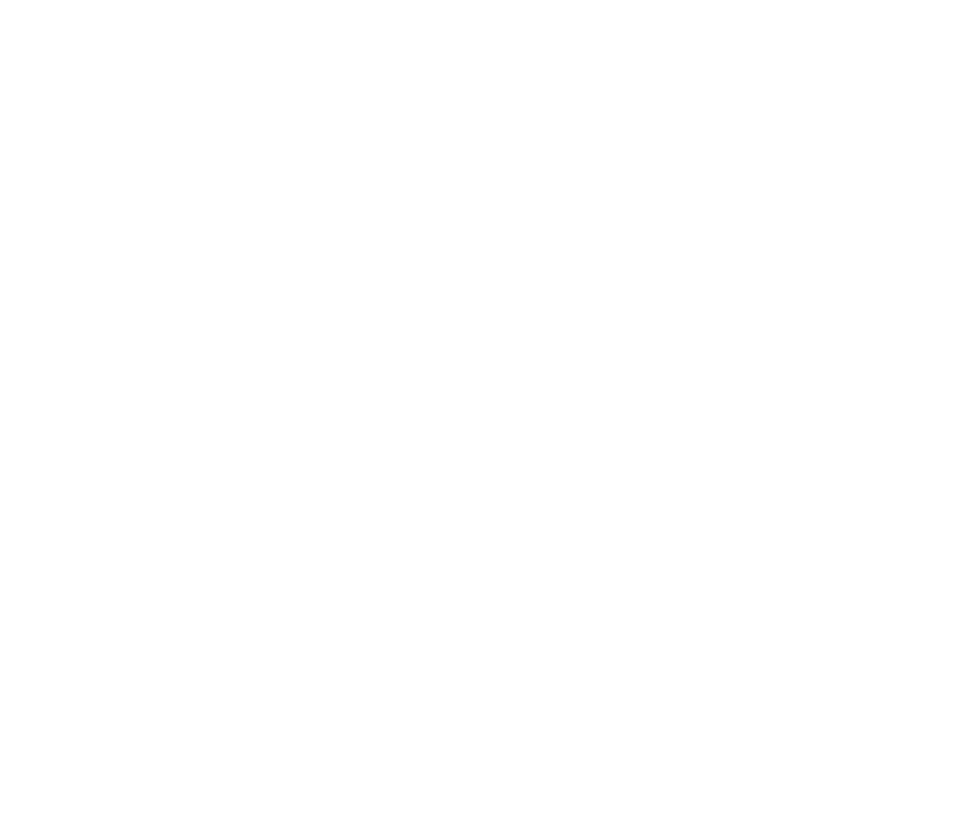

NameError: name 'Data' is not defined

In [9]:

plt.figure(figsize=(8,7))
Data = Data.sort_values(by=Key)
# Data.index = Data[Key]

Data = Data[np.isfinite(Data['True'])]

plt.scatter(RST.Master[Key],RST.Master[target],edgecolor='black',facecolor='white')
plt.plot(Data[Key],Data[target],
         label= params['target']+' Model\nr^2: '+str(np.round(metrics.r2_score(Data['True'],
                                                                   Data[params['target']])**2,3)))
# plt.plot(Data.index,Data['Var'],label= params['target']+
# ' Model\nRMSE: '+str(np.round(metrics.mean_squared_error(Data['True'],
#                                                                    Data[params['target']])**2,3)))


plt.fill_between(Data[Key], Data[target]-Data['PI'], 
                 Data[target]+Data['PI'],  color = 'green', alpha = 0.4, 
                 label = '95% PI')
plt.fill_between(Data[Key], Data[target]-Data['CI'], 
                 Data[target]+Data['CI'],  color = 'red', alpha = 0.4, 
                 label = '95% CI')
plt.legend()
# print(RST.Master)

plt.figure()

# plt.plot(Data[Key], Data['Var'])

plt.scatter(Data[target],Data['True'])

# print(Data['SE'])